In [ ]:
гит https://github.com/Starratel/-

In [ ]:
Сcылка на датасет: https://www.kaggle.com/datasets/shivamparab/amazon-electronics-reviews?resource=download

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8520 entries, 0 to 8519
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userID     8520 non-null   object 
 1   productID  8520 non-null   object 
 2   rating     8520 non-null   float64
dtypes: float64(1), object(2)
memory usage: 199.8+ KB
None


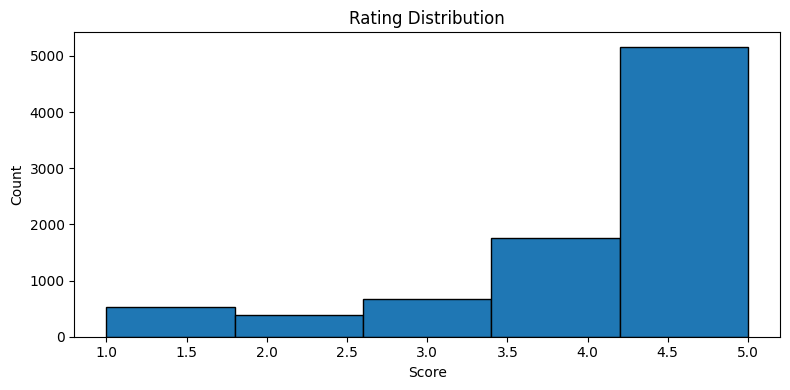

Уникальных пользователей: 7492
Уникальных товаров:    336
Random Forest RMSE: 1.2846
XGBoost RMSE: 1.1646
Stacking RMSE: 1.1605


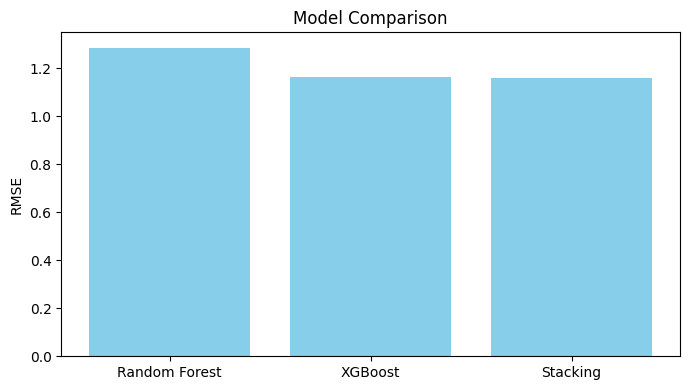

XGBoost после настройки RMSE: 1.2000


In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from math import sqrt
import xgboost as xgb
import json
import pandas as pd

d = []
l = 100_000

with open("Electronics_5.json", "r") as file:
    for idx, line in enumerate(file):
        if idx == l:
            break
        try:
            entry = json.loads(line.strip())
            d.append(entry)
        except:
            continue

df = pd.DataFrame(d)
df = df[["reviewerID", "asin", "overall"]]
df.columns = ["userID", "productID", "rating"]
df.to_csv("electronics2.csv", index=False)

dataset = pd.read_csv("electronics2.csv")
print(dataset.info())

if dataset.isnull().values.any():
    print("Missing values found!")

plt.figure(figsize=(8, 4))
plt.hist(dataset["rating"], bins=5, edgecolor="black")
plt.title("Rating Distribution")
plt.xlabel("Score")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

user_enc = LabelEncoder()
product_enc = LabelEncoder()

features = pd.DataFrame()
features["user_enc"] = user_enc.fit_transform(dataset["userID"])
features["product_enc"] = product_enc.fit_transform(dataset["productID"])
target = dataset["rating"]

print("Уникальных пользователей:", features["user_enc"].nunique())
print("Уникальных товаров:   ", features["product_enc"].nunique())

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=101
)

rf = RandomForestRegressor(n_estimators=25, random_state=101)
xgb_model = xgb.XGBRegressor(n_estimators=25, random_state=101)

ensemble = StackingRegressor(
    estimators=[("rf", rf), ("xgb", xgb_model)],
    final_estimator=LinearRegression()
)

for model in [rf, xgb_model, ensemble]:
    model.fit(X_train, y_train)

pred_rf = rf.predict(X_test)
pred_xgb = xgb_model.predict(X_test)
pred_stack = ensemble.predict(X_test)

rmse_values = {
    "Random Forest": sqrt(mean_squared_error(y_test, pred_rf)),
    "XGBoost":       sqrt(mean_squared_error(y_test, pred_xgb)),
    "Stacking":      sqrt(mean_squared_error(y_test, pred_stack))
}

for name, score in rmse_values.items():
    print(f"{name} RMSE: {score:.4f}")

plt.figure(figsize=(7, 4))
plt.bar(rmse_values.keys(), rmse_values.values(), color="skyblue")
plt.ylabel("RMSE")
plt.title("Model Comparison")
plt.tight_layout()
plt.show()

xgb_tuned = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=8,
    random_state=101
)

xgb_tuned.fit(X_train, y_train)
pred_xgb_tuned = xgb_tuned.predict(X_test)

rmse_xgb_tuned = sqrt(mean_squared_error(y_test, pred_xgb_tuned))
print(f"XGBoost после настройки RMSE: {rmse_xgb_tuned:.4f}")